<a href="https://colab.research.google.com/github/milad-s5/DL_HW3_RNN/blob/LSTM/1_Sentiment_1400_LSTM_BiLSTM_pBLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd 'drive/MyDrive/Colab Notebooks/DL/HW3/'

/content/drive/MyDrive/Colab Notebooks/DL/HW3


In [ ]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip -P data
!unzip -n -d data "data/trainingandtestdata.zip"

File ‘data/trainingandtestdata.zip’ already there; not retrieving.

Archive:  data/trainingandtestdata.zip


In [ ]:
# Download and unzip glove.42B.300d file if it doesn't exist
!wget -nc http://nlp.stanford.edu/data/glove.42B.300d.zip
!unzip -n "glove.42B.300d.zip"

File ‘glove.42B.300d.zip’ already there; not retrieving.

Archive:  glove.42B.300d.zip


In [ ]:
! ls -all -h

total 6.5G
-rw------- 1 root root 311K Jan  9 06:48 1.ipynb
-rw------- 1 root root 128K Jan  8 15:48 Cashe.ipynb
drwx------ 2 root root 4.0K Jan  1 08:52 data
-rw------- 1 root root 4.7G Oct 24  2015 glove.42B.300d.txt
-rw------- 1 root root 1.8G Oct 25  2015 glove.42B.300d.zip
drwx------ 2 root root 4.0K Jan  3 12:04 models
-rw------- 1 root root  83K Jan  9 06:20 Untitled0.ipynb


In [ ]:
! ls ./data -all -h

total 306M
-rw------- 1 root root  73K Mar  4  2010 testdata.manual.2009.06.14.csv
-rw------- 1 root root 228M Mar  4  2010 training.1600000.processed.noemoticon.csv
-rw------- 1 root root  78M Apr 22  2012 trainingandtestdata.zip


# Preprocessing

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer #
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences #
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, Embedding, concatenate 
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

# nltk
import re
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
traindf = pd.read_csv("data/training.1600000.processed.noemoticon.csv",
                names=['polarity', 'id', 'date', 'query', 'user', 'text'],
                encoding='latin-1')
traindf.head()

,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
testdf = pd.read_csv("data/testdata.manual.2009.06.14.csv",
                names=['polarity', 'id', 'date', 'query', 'user', 'text'],
                encoding='latin-1')

testdf.head()

,polarity,id,date,query,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


## Update polarity
`polarity` column:
`0` : negative, `4` : positive

Change that to `0` and `1`

In [ ]:
traindf.polarity.value_counts()

4    800000
0    800000
Name: polarity, dtype: int64

In [ ]:
testdf.polarity.value_counts()

4    182
0    177
2    139
Name: polarity, dtype: int64

In [ ]:
traindf.polarity = traindf.polarity.replace({0: 0, 4: 1})
traindf.polarity.value_counts()

1    800000
0    800000
Name: polarity, dtype: int64

In [ ]:
testdf = testdf[testdf.polarity != 2]
testdf.polarity = testdf.polarity.replace({0: 0, 4: 1})
testdf.polarity.value_counts()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


1    182
0    177
Name: polarity, dtype: int64

## Remove unneeded columns

We don't need all those columns! Let's get rid of the ones that won't affect the sentiment.

In [ ]:
traindf = traindf.drop(columns=['id', 'date', 'query', 'user'])
testdf = testdf.drop(columns=['id', 'date', 'query', 'user'])

In [ ]:
traindf

,polarity,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


## Remove link,user and special characters


In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english") # Snowball Stemmer – NLP

In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub("@\S+|#\S+|https?:\S+|http?:\S", ' ', str(text).lower()).strip() # Remove user ids, hashtags and links
    text = re.sub("[^A-Za-z0-9]+", ' ', str(text).lower()).strip()            # Remove special characters 
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
traindf.text = traindf.text.apply(lambda x: preprocess(x))
testdf.text = testdf.text.apply(lambda x: preprocess(x))

In [ ]:
traindf

,polarity,text
0,0,awww bummer shoulda got david carr third day
1,0,upset update facebook texting might cry result...
2,0,dived many times ball managed save 50 rest go ...
3,0,whole body feels itchy like fire
4,0,behaving mad see
...,...,...
1599995,1,woke school best feeling ever
1599996,1,thewdb com cool hear old walt interviews
1599997,1,ready mojo makeover ask details
1599998,1,happy 38th birthday boo alll time tupac amaru ...


## Train, valid

In [ ]:
## Find length of longest tweet(for embedding)
length_of_the_tweets = traindf['text'].str.split("\\s+")

print(length_of_the_tweets)
print('Max number of words = ', length_of_the_tweets.str.len().max())
print('Index = ', length_of_the_tweets.str.len().idxmax())

0          [awww, bummer, shoulda, got, david, carr, thir...
1          [upset, update, facebook, texting, might, cry,...
2          [dived, many, times, ball, managed, save, 50, ...
3                    [whole, body, feels, itchy, like, fire]
4                                       [behaving, mad, see]
                                 ...                        
1599995                  [woke, school, best, feeling, ever]
1599996     [thewdb, com, cool, hear, old, walt, interviews]
1599997                [ready, mojo, makeover, ask, details]
1599998    [happy, 38th, birthday, boo, alll, time, tupac...
1599999                                              [happy]
Name: text, Length: 1600000, dtype: object
Max number of words =  50
Index =  1447652


In [ ]:
TRAIN_SIZE = 0.8
MAX_SEQUENCE_LENGTH = length_of_the_tweets.str.len().max() # 50

In [ ]:
train_data, valid_data = train_test_split(traindf, test_size=1-TRAIN_SIZE, random_state=7) 
test_data = testdf
print("Train Data size: ", len(train_data))
print("Valid Data size:  ", len(valid_data))
print("Test Data size:  ", len(test_data))

Train Data size:  1280000
Valid Data size:   320000
Test Data size:   359


In [ ]:
train_data

,polarity,text
23786,0,need friends
182699,0,im trying call impossible
476661,0,good pace going 3k 13 min missed 5k turn ended...
1181490,1,u gonna shows ny soon luv see u live
878773,1,hell yea get em tattoos ink free wish parents ...
...,...,...
839891,1,say anything amsterdam tom wrote plan come eur...
535030,0,wishing back nyc pals
573977,0,itunes store says quot download free updates q...
1238212,1,sunburnt british weather good times x


bert

In [ ]:
! pip install transformers

In [ ]:
# hyperparameters
max_length = 50 #140
batch_size = 512

In [ ]:
from transformers import BertTokenizer, TFBertModel

In [ ]:
# Bert Tokenizer
model_name = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

In [ ]:
def bert_encode(data):
    tokens = tokenizer.batch_encode_plus(data, max_length=max_length, padding='max_length', truncation=True)
    return tf.constant(tokens['input_ids'])

In [ ]:
bert_encode(train_data.text)

ValueError: ignored

In [ ]:
bert_encode(train_data.text[12])

<tf.Tensor: shape=(39, 50), dtype=int32, numpy=
array([[101, 171, 102, ...,   0,   0,   0],
       [101, 174, 102, ...,   0,   0,   0],
       [101, 170, 102, ...,   0,   0,   0],
       ...,
       [101, 178, 102, ...,   0,   0,   0],
       [101, 183, 102, ...,   0,   0,   0],
       [101, 176, 102, ...,   0,   0,   0]], dtype=int32)>

In [ ]:
bert_encode('h')

{'input_ids': [[101, 177, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


<tf.Tensor: shape=(1, 50), dtype=int32, numpy=
array([[101, 177, 102,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
      dtype=int32)>

In [ ]:
tokenizer.encode_plus('jghj uhlkj', max_length=max_length, padding='max_length', truncation=True)

{'input_ids': [101, 179, 5084, 3361, 14863, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

bert

## Tokenization

In [ ]:
tokenizer = Tokenizer() # create tokens for every word in the data corpus and map them to a index using dictionary
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index # contains the index for each word
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 240624


In [ ]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_valid = pad_sequences(tokenizer.texts_to_sequences(valid_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Train X Shape:",x_train.shape)
print("Valid X Shape:",x_valid.shape)
print("Test X Shape:",x_test.shape)

Train X Shape: (1280000, 50)
Valid X Shape: (320000, 50)
Test X Shape: (359, 50)


In [ ]:
labels = train_data.polarity.unique().tolist()

## Label Encoding

In [ ]:
encoder = LabelEncoder()
encoder.fit(train_data.polarity.to_list())

y_train = encoder.transform(train_data.polarity.to_list())
y_valid = encoder.transform(valid_data.polarity.to_list())
y_test  = encoder.transform(test_data.polarity.to_list())

y_train = y_train.reshape(-1,1)
y_valid = y_valid.reshape(-1,1)
y_test  = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_valid shape: ", y_valid.shape)
print("y_test shape: ", y_test.shape)

y_train shape: (1280000, 1)
y_valid shape:  (320000, 1)
y_test shape:  (359, 1)


## Word Emdedding

In [ ]:
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10

In [ ]:
embeddings_index = {}

f = open('./glove.42B.300d.txt')
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 1917494 word vectors.


In [ ]:
embeddings_val = embeddings_index.values() 
embeddings_mean = sum(list(embeddings_val))/len(list(embeddings_val))

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
  else:
    embedding_matrix[i] = embeddings_mean

In [ ]:
# Generates Embedding Vector for each input sequence
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

# Model Training

## LSTM

In [ ]:
def plot_curves(history):
	# plot loss
	plt.title('Cross Entropy Loss')
	plt.xlabel('Epoch')
	plt.ylabel('Loss')  
	plt.plot(history.history['loss'], label='train')
	plt.plot(history.history['val_loss'], label='valid')
	plt.legend() 
	plt.show()
	# plot accuracy
	plt.title('Classification Accuracy')
	plt.xlabel('Epoch')
	plt.ylabel('Accuracy')   
	plt.plot(history.history['accuracy'], label='train')
	plt.plot(history.history['val_accuracy'], label='valid')
	plt.legend()
	plt.show()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 300)           72187200  
                                                                 
 dropout_1 (Dropout)         (None, 50, 300)           0         
                                                                 
 lstm_15 (LSTM)              (None, 150)               270600    
                                                                 
 dense_15 (Dense)            (None, 1)                 151       
                                                                 
Total params: 72,457,951
Trainable params: 270,751
Non-trainable params: 72,187,200
_________________________________________________________________

Train model:

Epoch 1/10
1250/1250 [==============================] - 294s 232ms/step - loss: 0.4950 - accuracy: 0.7564 - val_loss: 0.4576 - val_accuracy: 0.7817
Epoc

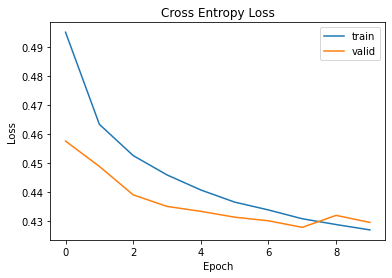

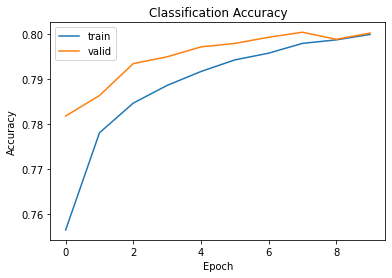

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(LSTM(150, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

print('\nTrain model:\n')
# ===================================================================
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_valid, y_valid))

# ===================================================================

print('\n ================================================================ \n')
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:    ", score[0])
print("Test accuracy:", score[1],'\n')

plot_curves(history)

# Save model
# model.save('./models/lstm.h5') 
# Load model: 
# model = load_model('./models/lstm.h5')

In [ ]:
def plot_confusion_matrix(y_test, y_prediction, class_names, Normalization=True):
  con = tf.math.confusion_matrix(labels=y_test, predictions=y_prediction, num_classes=2).numpy()
  df_cm = pd.DataFrame(con, index = [i for i in class_names], columns = [i for i in class_names])
  if Normalization == False:
    plt.figure(figsize = (6,6))
    sn.heatmap(df_cm, annot=True, fmt='.0f',annot_kws={"size": 9})
    plt.ylabel('Labels')
    plt.xlabel('Predictions')
    plt.title('Confusion Matrix')
  else:
    cmn = con.astype('float') / con.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cmn, index = [i for i in class_names], columns = [i for i in class_names])
    plt.figure(figsize = (6,6))
    sn.heatmap(df_cm, annot=True, fmt='.2f',annot_kws={"size": 9})
    plt.ylabel('Labels')
    plt.xlabel('Predictions')
    plt.title('Confusion Matrix')

In [ ]:
def decode_sentiment(score):
    return 1 if score>0.5 else 0

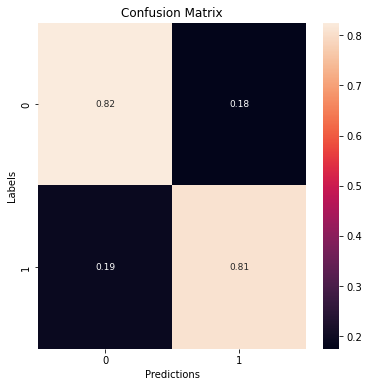

In [ ]:
model_out = model.predict(x_test)
y_pred = [decode_sentiment(x) for x in model_out]
plot_confusion_matrix(y_test, y_pred, [0,1])

## LSTM (Bidirectional)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 300)           72187200  
                                                                 
 dropout_1 (Dropout)         (None, 50, 300)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 300)              541200    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 301       
                                                                 
Total params: 72,728,701
Trainable params: 541,501
Non-trainable params: 72,187,200
_________________________________________________________________

Train model:

Epoch 1/10
1250/1250 [==============================] - 226s 177ms/step - loss: 0.4970 

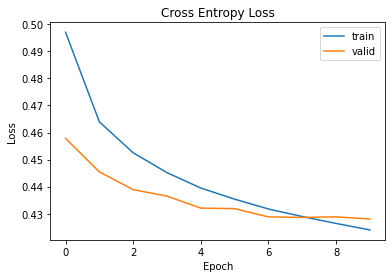

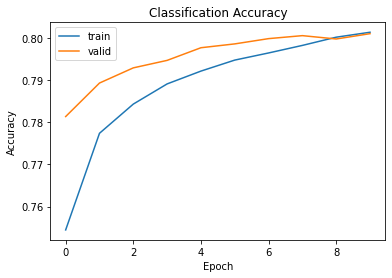

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(150, dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

print('\nTrain model:\n')
# ===================================================================
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_valid, y_valid))

# ===================================================================

print('\n ================================================================ \n')
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:    ", score[0])
print("Test accuracy:", score[1],'\n')

plot_curves(history)

# save model
model.save('./models/lstm_bidirect1.h5')

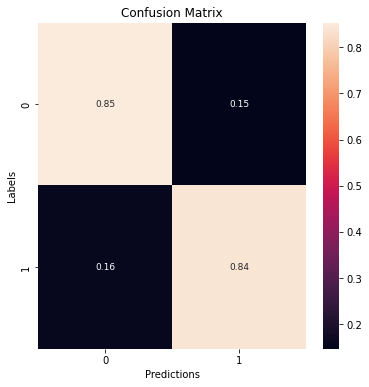

In [ ]:
model_out = model.predict(x_test)
y_pred = [decode_sentiment(x) for x in model_out]
plot_confusion_matrix(y_test, y_pred, [0,1])

## Pyramid structure

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 300)           72187200  
                                                                 
 dropout (Dropout)           (None, 50, 300)           0         
                                                                 
 lstm (LSTM)                 (None, 50, 64)            93440     
                                                                 
 average_pooling1d (AverageP  (None, 25, 64)           0         
 ooling1D)                                                       
                                                                 
 lambda (Lambda)             (None, 25, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 25, 32)            12416     
                                                        

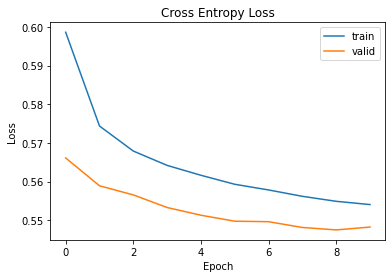

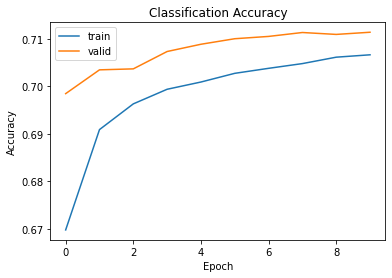

In [ ]:
model = Sequential()
model.add(embedding_layer)
#model.add(tf.keras.Input(shape=(None, 300)))
model.add(Dropout(0.2))
model.add(LSTM(64, dropout=0.2,return_sequences=True))
model.add(tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Lambda(lambda x: x * [2])) 
model.add(LSTM(32, dropout=0.2,return_sequences=True))
model.add(tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Lambda(lambda x: x * [2])) 
model.add(LSTM(16, dropout=0.2,return_sequences=True))
model.add(tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Lambda(lambda x: x * [2])) 
model.add(LSTM(8, dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

print('\nTrain model:\n')
# ===================================================================
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_valid, y_valid))

# ===================================================================

print('\n ================================================================ \n')
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:    ", score[0])
print("Test accuracy:", score[1],'\n')

plot_curves(history)

# save model
# model.save('./models/pyramid.h5')

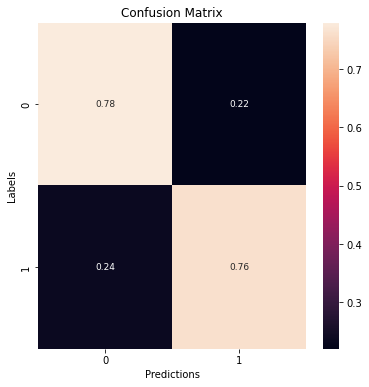

In [ ]:
model_out = model.predict(x_test)
y_pred = [decode_sentiment(x) for x in model_out]
plot_confusion_matrix(y_test, y_pred, [0,1])

In [ ]:
x_train

array([[     0,      0,      0, ...,      0,     34,    110],
       [     0,      0,      0, ...,    133,    220,   2307],
       [     0,      0,      0, ...,   5609,   9841,   1055],
       ...,
       [     0,      0,      0, ...,    412, 163388,    702],
       [     0,      0,      0, ...,   2344,  19810,   3815],
       [     0,      0,      0, ...,     19,    162,    183]], dtype=int32)